# Setup

In [80]:
%load_ext autoreload
%autoreload 2
%aimport

%matplotlib inline 

import torch
import matplotlib.pyplot as plt
from einops import rearrange

from bliss.catalog import TileCatalog, get_images_in_tiles
from bliss.encoder import Encoder


device = torch.device('cuda:0')
!echo $CUDA_VISIBLE_DEVICES

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:

5


In [81]:
# load models
from hydra import compose, initialize
from hydra.utils import instantiate

with initialize(config_path="../../sdss_galaxies/config"):
    cfg = compose("config", overrides=[])

# Load models

In [82]:
location = instantiate(cfg.models.detection_encoder).to(device).eval()
location.load_state_dict(
    torch.load(cfg.plots.location_checkpoint, map_location=location.device)
)

<All keys matched successfully>

In [83]:
encoder = Encoder(location.eval(), n_images_per_batch=10, n_rows_per_batch=15).to(device)

# Load datasets

## Unhomogenized

In [84]:
with initialize(config_path="../config"):
    cfg = compose("config", overrides=[])

In [87]:
ds = instantiate(cfg.datasets.galsim_blends, batch_size=512, n_batches=20, num_workers=20)

Generating dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.52it/s]


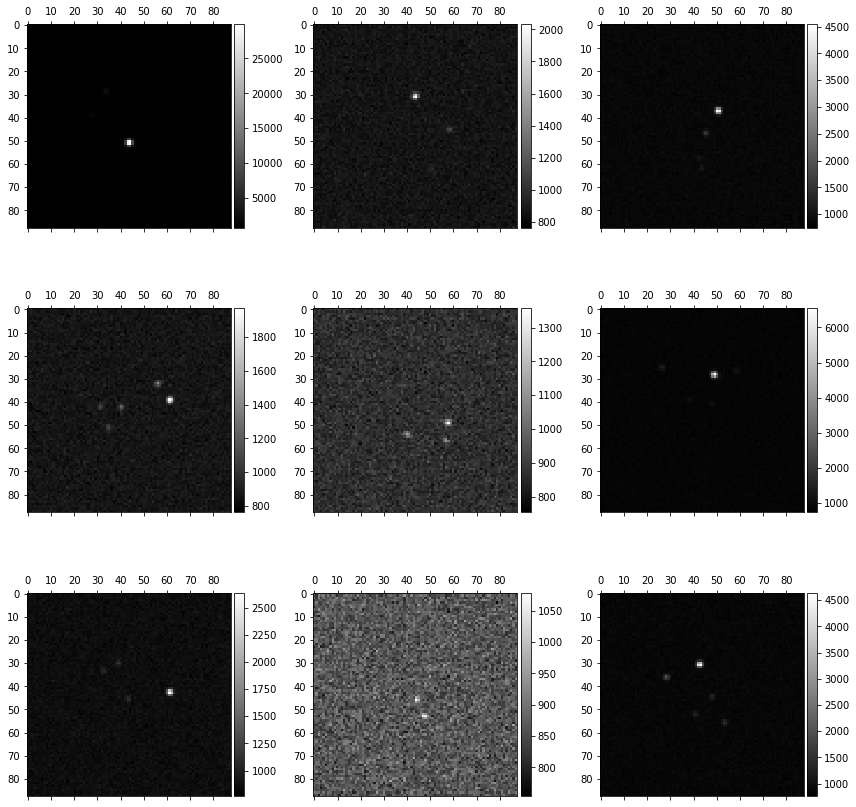

In [92]:
from bliss.generate import generate
generate(ds, '../output/unhomo_dataset.pt', '../output/unhomo_dataset.png', 9, global_params=("background",))

## Homogenized

In [93]:
with initialize(config_path="../config"):
    cfg = compose("config", overrides=[])

In [94]:
ds = instantiate(cfg.datasets.galsim_blended_std_psf, batch_size=512, n_batches=20, num_workers=20)

Generating dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.52it/s]


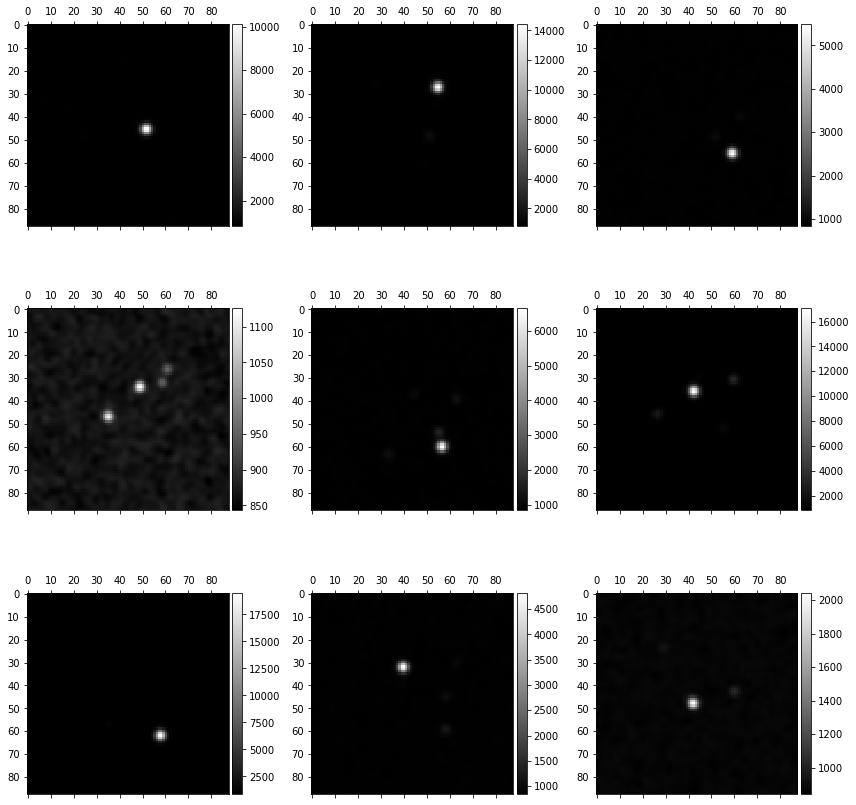

In [100]:
from bliss.generate import generate
generate(ds, '../output/homo_dataset.pt', '../output/homo_images.png', 9, global_params=("background",))

# Run model on saved dataset

In [101]:
sds = torch.load('../output/homo_dataset.pt')
sds['images'].shape

torch.Size([10240, 1, 88, 88])

In [102]:
n_batches = sds['images'].shape[0]
slen = sds['images'].shape[-1]
background = rearrange(sds['background'], '1 h w -> 1 1 h w')
background = background.expand(n_batches, 1, slen, slen)
tile_est = encoder.variational_mode(sds['images'], background)


Encoding ptiles: 1024it [00:33, 30.46it/s]


In [ ]:
tile_est = unhomo_encoder.variational_mode(sds['noisy_images'], background)


# Metrics on prediction compared to truth

In [103]:
est = tile_est.cpu().to_full_params() # full estimated catalog

In [104]:
sds["star_fluxes"].shape

torch.Size([10240, 10, 10, 1, 1])

In [107]:
catalog_dict = {
    "locs": sds["locs"][:, :, :, 0 : 1],
    "star_log_fluxes": sds["star_fluxes"][:, :, :, 0 : 1],
    "galaxy_bools": sds["star_bools"][:, :, :, 0 : 1],
    "n_sources": sds["n_sources"].clamp(max=1),
}
true_tile_catalog = TileCatalog(4, catalog_dict)
truth = true_tile_catalog.to_full_params()

In [109]:
truth.plocs.shape

torch.Size([10240, 6, 2])

In [111]:
from bliss.reporting import DetectionMetrics
metrics = DetectionMetrics()(truth, est)
metrics['f1']

In [116]:
print(truth.n_sources)
print(est.n_sources)

tensor([2, 5, 3,  ..., 2, 1, 1])
tensor([2, 4, 4,  ..., 2, 1, 1])
